# <span style="color:#ff884d">CytoMod</span>

<b>Wellcome to the CytoMod example Jupyter Notebook!</b><br>
The full paper describing the method can be found at<br>
https://www.frontiersin.org/articles/10.3389/fimmu.2019.01338/<br>
This notebook runs over an example dataset from the FLU09 study.<br><br>
In order to run the notebook yourself with <span style="color:blue">your own data</span>, download the CytoMod folder from https://github.com/liel-cohen/CytoMod. The folder contains a folder <i>data_files/data</i> that contains files named <i>cytokine_data.xlsx</i> and <i>patient_data.xlsx</i>, which hold the data for the notebook analysis. In the folder you have downloaded, you can replace these files with your own data files while following the format instructions bellow.

* <i>cytokine_data.xlsx</i>: cytokine_data.xlsx: the first column is the subject IDs
(named PTID in the example file) which will be converted
to row indexes. If your dataset has no subject IDs,
change 'indexCol=0' to 'indexCol=None', in both cy_data and patients_data
initialization (under the <span style="color:purple">Import data</span> header).
The next columns are your cytokines data. Each column should have
the raw cytokine measurment for the subject indicated in the specific row.

* <i>patient_data.xlsx</i>: Optional file for patient outcomes, for the associations to outcomes analysis. The first column is the subject IDs (named PTID in the example file). The instructions regarding the IDs are the same as for the <i>cytokine_data.xlsx</i> file. This dataframe should contain outcome variables to be analyzed in the associations to outcomes analysis. It may also contain covariate variables for controlling the regression models built for the associations calculation.

A folder named 'output' will be created by the code inside the <i>data_files</i> folder. The code writes all results and figures into this folder.<br>
See the <span style="color:purple">Define arguments</span> section for further instructions for this analysis.<br><br>

The code was written using the Anaconda3 Python interpreter and packages.
The palettable module (https://pypi.org/project/palettable/) must also be installed.


## <span style="color:purple">1. Imports</span>

In [1]:
import os
import sys
import pandas as pd
sys.path.append(os.path.join(os.getcwd(), 'cytomod', 'otherTools'))
import matplotlib.pyplot as plt
import cytomod
import cytomod.run_gap_statistic as gap_stat
import cytomod.assoc_to_outcome as outcome
from cytomod import plotting as cyplot
from hclusterplot import plotHColCluster
import tools
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## <span style="color:purple">2. Define input arguments</span>
* args.name_data
       Name of dataset/cohort (for writing files)
* args.name_compartment
       Name of compartment from which cytokines were extracted, e.g., serum (for writing files)
* args.cytokines
        List of cytokines to be analyzed. If None, will analyze all cytokines in the cytokine_data file.
* args.log_transform
       Boolean indicating whether to perform a log (base 10) transformation (True) or not (False).
* args.outcomes
       Optional. Names of outcome variables from the patients_data.xlsx data-frame to be analyzed.
       If list is left empty (i.e., []), will not perform the associations to outcomes analysis.
       This code currently supports binary outcome variables only, by using logistic regression.
* args.covariates
       Optional. Names of covariate variables (columns) from the patients_data.xlsx data-frame 
       to be controlled for in the regression models. If list is left empty (i.e., []), 
       will not controll the associations to outcomes analysis with any covariate variables.
* args.log_column_names
        List with names of covariate columns to be log-transformed, only if args.log_transform = True. 
        If there are no columns you wish to transform, leave empty (i.e., [])
* args.max_testing_k
        Maximal number of clusters to test the gap statistic for.
* args.max_final_k
        The maximal number of clusters that can be chosen based on the
        gap statistic.
* args.recalculate_best_k 
        Boolean. Set to True if you want the gap statistic (for finding the best K)
        to be recalcultaed in the current run.
        After calculation, the calculated best K will be saved to files,
        and used by the code until the next time you decide to recalculate them,
        or if the best K files are deleted. If no best K files are found, will
        recalculate best K anyway.

### <span style="color:#5757db">2.1 Manually define input arguments </span>

In [3]:
args = tools.Object()

args.name_data = 'FLU09'
args.name_compartment = 'Plasma'

args.log_transform = True
args.max_testing_k = 8
args.max_final_k = 6 # Must be <= max_testing_k
args.recalculate_best_k = False
args.outcomes = ['FluPositive'] # names of binary outcome columns
args.covariates = ['Age'] # names of regression covariates to control for
args.log_column_names = ['Age'] # or empty list: []
args.cytokines = None # if none, will analyze all

### <span style="color:#5757db">2.2 Folder Paths</span>

In [4]:
args.path_files = os.path.join(os.getcwd(), 'data_files')

args.paths = {'files': os.path.join(os.getcwd(), 'data_files'),
              'data': os.path.join(os.getcwd(), 'data_files', 'data'),
              'gap_statistic': os.path.join(os.getcwd(), 'data_files', 'output', 'gap_statistic'),
              'clustering': os.path.join(os.getcwd(), 'data_files', 'output', 'clustering'),
              'clustering_info': os.path.join(os.getcwd(), 'data_files', 'output', 'clustering', 'info'),
              'clustering_figures': os.path.join(os.getcwd(), 'data_files', 'output', 'clustering', 'figures'),
              'correlation_figures': os.path.join(os.getcwd(), 'data_files', 'output', 'correlations'),
              'association_figures': os.path.join(os.getcwd(), 'data_files', 'output', 'associations'),
              }

tools.create_folder(args.paths['gap_statistic'])
tools.create_folder(args.paths['clustering_info'])
tools.create_folder(args.paths['clustering_figures'])
tools.create_folder(args.paths['correlation_figures'])
tools.create_folder(args.paths['association_figures'])

### <span style="color:#5757db">2.3 Make sure input arguments are valid</span>

In [5]:
assert type(args.name_data) is str
assert type(args.name_compartment) is str
assert type(args.log_transform) is bool
assert type(args.max_testing_k) is int
assert type(args.max_final_k) is int
assert args.max_final_k <= args.max_testing_k
assert type(args.outcomes) is list
assert type(args.covariates) is list

for col_name in args.outcomes + args.covariates + args.log_column_names:
    assert type(col_name) is str
    tools.assert_column_exists_in_path(os.path.join(args.paths['data'], 'patient_data.xlsx'), col_name)

In [6]:
# If you got here -
print("Args are valid!")

Args are valid!


## <span style="color:purple">3. Import data</span>

### <span style="color:#5757db">3.1 Cytokine data</span>

In [7]:
cy_data = tools.read_excel(os.path.join(args.paths['data'], 'cytokine_data.xlsx'),
                           indexCol=0)
cy_data.dropna(axis='index', how='all', inplace=True)

if args.cytokines is None:
    args.cytokines = list(cy_data.columns)

# Only cytokines contained in args.cytokines list
cy_data = cy_data[args.cytokines]

In [8]:
# See first 5 rows of the cytokines dataframe
cy_data.head()

,EGF,Eotaxin,FGF-2,FLT3L,FKN,GCSF,GM-CSF,GRO,IFNα2,IFNγ,...,MCP1,MCP3,MDC,MIP1α,MIP1β,sCD40-L,TGFα,TNFα,TNFβ,VEGF
ID,,,,,,,,,,,,,,,,,,,,,
3200,5.24,24.34,39.02,1.94,20.86,39.52,6.60,98.41,8.12,9.97,...,199.33,9.66,775.28,3.01,18.40,530.95,1.39,15.25,2.09,113.09
3202,179.16,39.41,28.62,2.50,49.11,20.92,356.27,1019.90,27.21,8.36,...,2737.32,67.07,1158.00,171.51,150.73,10859.95,3.61,15.93,1.61,77.21
3204,191.72,42.49,7.68,0.67,33.36,10.44,22.71,2038.28,25.98,7.36,...,159.52,6.66,1867.52,8.43,35.67,11849.41,2.36,4.91,0.53,45.34
3206,132.00,93.76,33.89,0.47,128.00,67.87,147.00,4132.00,27.43,13.54,...,301.00,23.69,1139.00,208.00,110.00,13420.00,24.26,14.16,0.59,32.60
3209,12.91,18.75,17.37,2.50,2.62,12.83,231.27,149.67,6.48,63.64,...,98.76,7.09,965.21,49.08,1.51,250.07,1.90,0.68,1.61,400.35


### <span style="color:#5757db">3.2 Patients data</span>

In [9]:
if args.outcomes != []:
    patient_data = tools.read_excel(os.path.join(args.paths['data'], 'patient_data.xlsx'),
                                indexCol=0)
    patient_data.dropna(axis='index', how='all', inplace=True)
    
    # See first 5 rows of the patients dataframe
    patient_data.head()

In [10]:
# log transform cytokines and args.log_column_names
if args.log_transform:
    cy_data = np.log10(cy_data)

    if args.log_column_names != [] and args.outcomes != []:
        for col_name in args.log_column_names:
            new_col_name = 'log_' + col_name

            # log transform variable
            patient_data[new_col_name] = np.log10(patient_data[col_name])

            # standardize variable
            standardizeFunc = lambda col: (col - np.nanmean(col)) / np.nanstd(col)
            patient_data[[new_col_name]] = patient_data[[new_col_name]].apply(standardizeFunc)

            # replace column with new log transformed column
            if col_name in args.covariates:
                args.covariates.remove(col_name)
                args.covariates.append(new_col_name)

## <span style="color:purple">4. Adjust Cytokines</span>

In [11]:
# Adjust
cyto_mod_adj = cytomod.cytomod_class(args.name_data, args.name_compartment, True, cy_data)
cyto_mod_abs = cytomod.cytomod_class(args.name_data, args.name_compartment, False, cy_data)
cyto_modules = {'adj': cyto_mod_adj, 'abs': cyto_mod_abs}

### <span style="color:#5757db">4.1 Absolute cytokines visualization</span>

#### <span style="color:#8080b3">4.1.1 Pearson pairwise correlations</span>

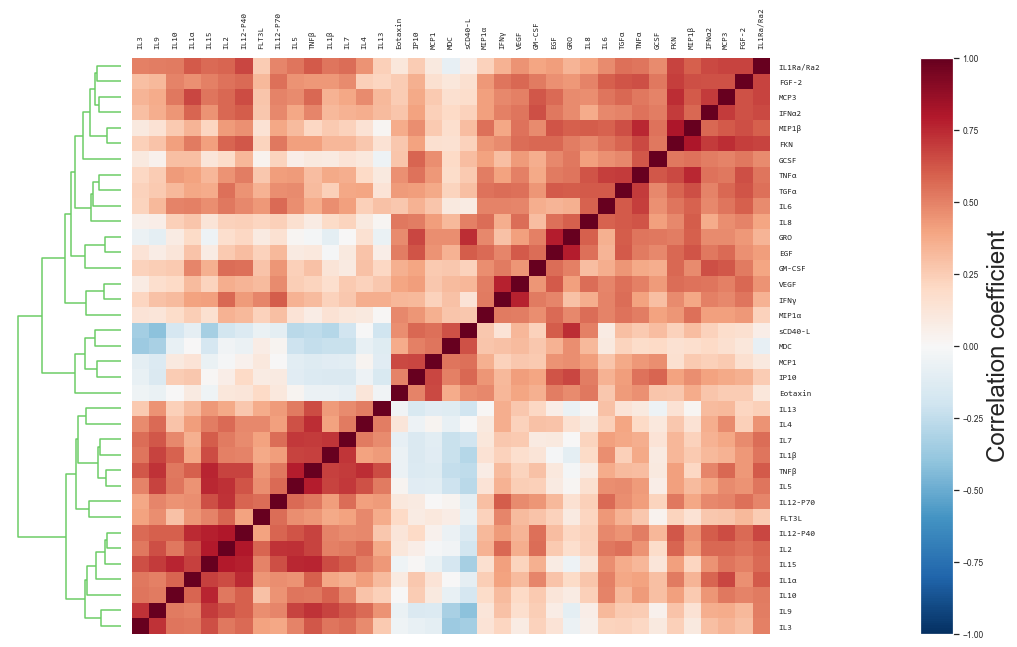

In [12]:
cols = plotHColCluster(cyto_modules['abs'].cyDf, method='complete',
                     metric='pearson-signed',
                     save_path=os.path.join(args.paths['correlation_figures'],
                                            '%s_correlation_heatmap.png' % cyto_modules['abs'].name))

#### <span style="color:#8080b3">4.1.2 Pearson correlation to the mean</span>

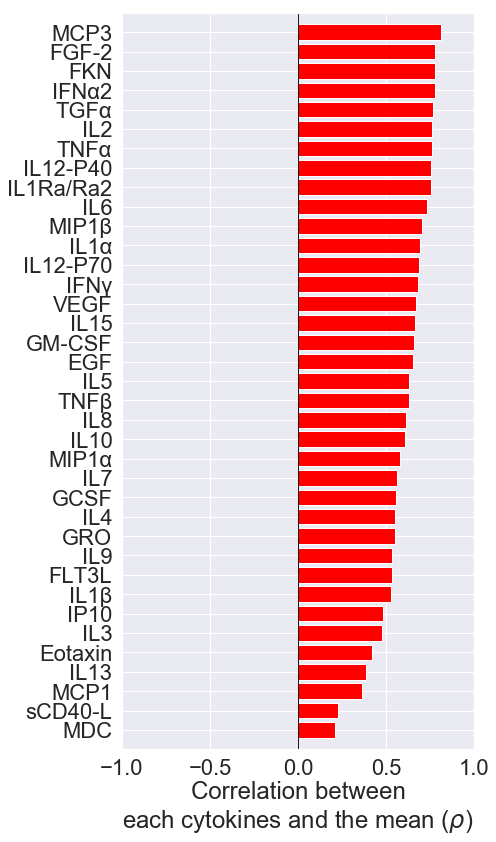

In [13]:
cyplot.plotMeanCorr(cyto_modules['abs'].withMean, cyto_modules['abs'].meanS.name,
                    cyList=sorted(cyto_modules['abs'].cyDf.columns),
                    save_path=os.path.join(args.paths['correlation_figures'],
                                           '%s_cy_mean_correlation.png' % cyto_modules['abs'].name))

### <span style="color:#5757db">4.2 Adjusted cytokines visualization</span>

#### <span style="color:#8080b3">4.2.1 Pearson pairwise correlations</span>

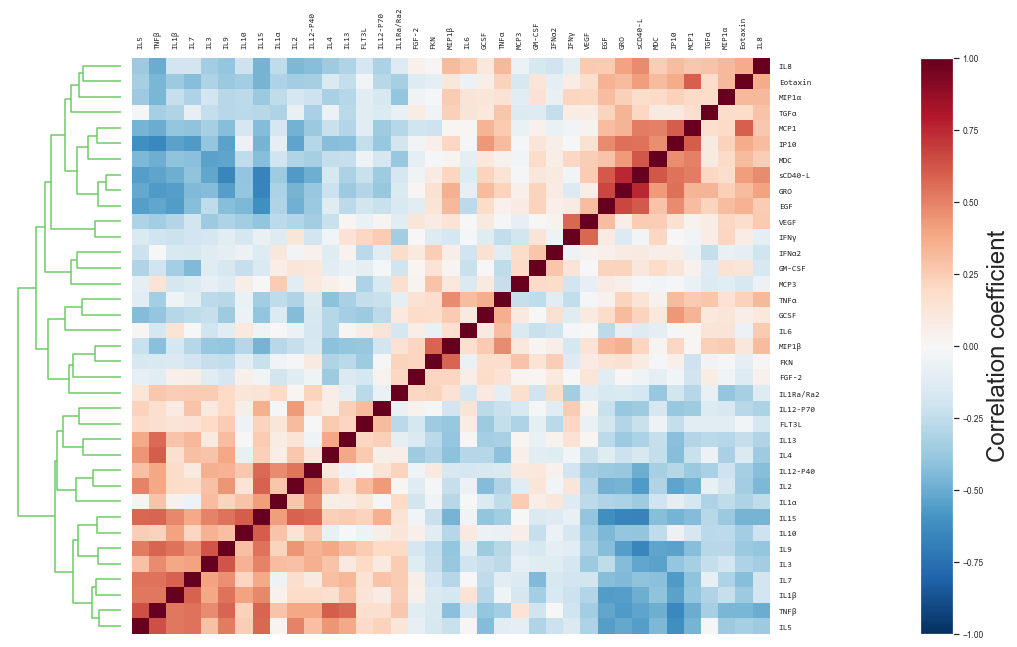

In [14]:
cols = plotHColCluster(cyto_modules['adj'].cyDf, method='complete',
                     metric='pearson-signed',
                     save_path=os.path.join(args.paths['correlation_figures'],
                                            '%s_correlation_heatmap.png' % cyto_modules['abs'].name))

## <span style="color:purple">5. Clustering</span>

### <span style="color:#5757db">5.1 Get best K</span>

In [15]:
# Get best K. If first time or args.recalculate_best_k=True - compute best K. Otherwise - read from file.
if args.recalculate_best_k or not os.path.exists(os.path.join(args.paths['clustering'], 'bestK.xlsx')):
    k_abs = gap_stat.getBestK(cyto_modules['abs'].cyDf,
                                       max_testing_k=args.max_testing_k,
                                       max_final_k=args.max_final_k,
                                       save_fig_path=os.path.join(args.paths['gap_statistic'], 'gap_stat_abs.png'))

In [16]:
# Get best K. If first time or args.recalculate_best_k=True - compute best K. Otherwise - read from file.
if args.recalculate_best_k or not os.path.exists(os.path.join(args.paths['clustering'], 'bestK.xlsx')):
    k_adj = gap_stat.getBestK(cyto_modules['adj'].cyDf,
                                       max_testing_k = args.max_testing_k,
                                       max_final_k=args.max_final_k,
                                       save_fig_path=os.path.join(args.paths['gap_statistic'], 'gap_stat_adj.png'))

In [17]:
# If first time - write best K to bestK.xlsx file. Else - read from file.
if args.recalculate_best_k or not os.path.exists(os.path.join(args.paths['clustering'], 'bestK.xlsx')):
    bestK = {'adj': k_adj, 'abs': k_abs}
    tools.write_DF_to_excel(os.path.join(args.paths['clustering'], 'bestK.xlsx'), bestK)
else:
    bestK = tools.read_excel(os.path.join(args.paths['clustering'], 'bestK.xlsx'))
    bestK = dict(bestK['value'])

##### Best K for absolute cytokines:

In [18]:
print(bestK['abs'])

5


##### Best K for adjusted cytokines:

In [19]:
print(bestK['adj'])

4


### <span style="color:#5757db">5.2 Cluster</span>

In [20]:
cyto_mod_adj.cluster_cytokines(K=bestK['adj'])
cyto_mod_abs.cluster_cytokines(K=bestK['abs'])

### <span style="color:#5757db">5.3 Absolute cytokines clustering results visualization</span>

#### <span style="color:#8080b3">5.3.1 Pearson pairwise correlations (with module colors)</span>

<Figure size 1116x684 with 0 Axes>

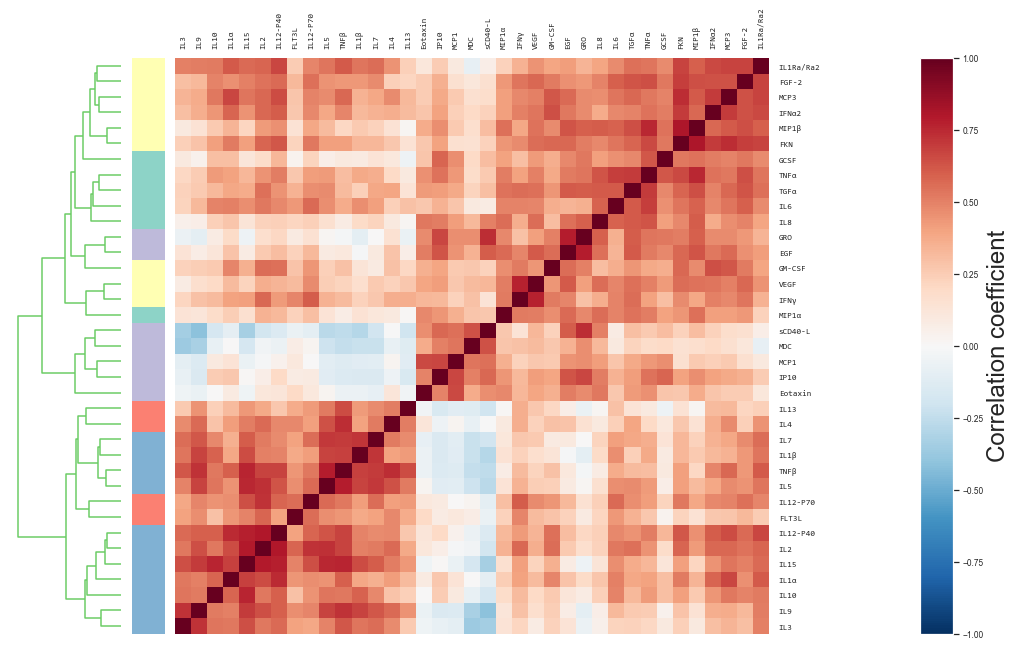

In [21]:
cytomod.io.plot_clustering_heatmap(cyto_modules['abs'], args.paths['clustering_figures'])

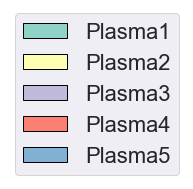

In [22]:
cytomod.io.plot_color_legend(cyto_modules['abs'], args.paths['clustering_figures'])

#### <span style="color:#8080b3">5.3.2 Pairwise same-cluster reliability (with module colors)</span>

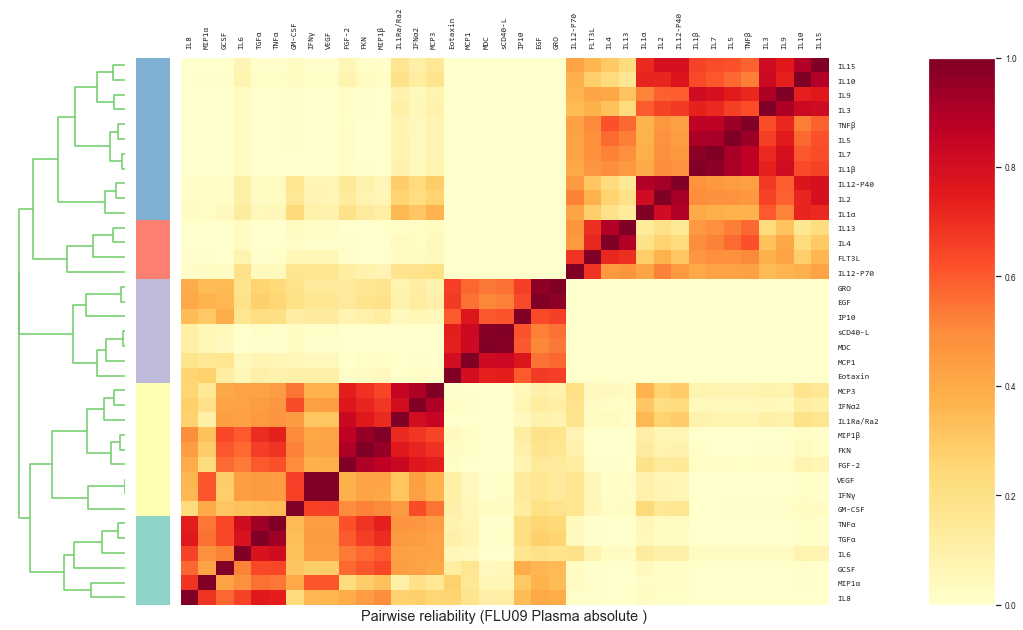

In [23]:
cytomod.io.plot_reliability(cyto_modules['abs'], args.paths['clustering_figures'])

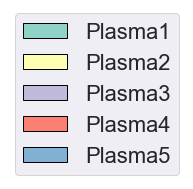

In [24]:
cytomod.io.plot_color_legend(cyto_modules['abs'], args.paths['clustering_figures'])

#### <span style="color:#8080b3">5.3.3 Modules cytokines correlations</span>

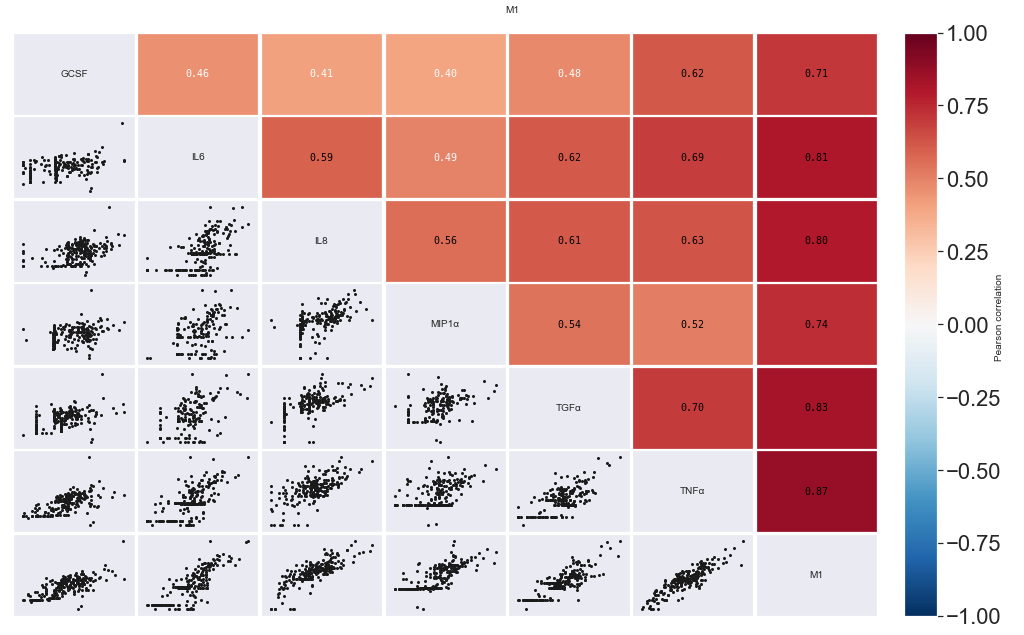

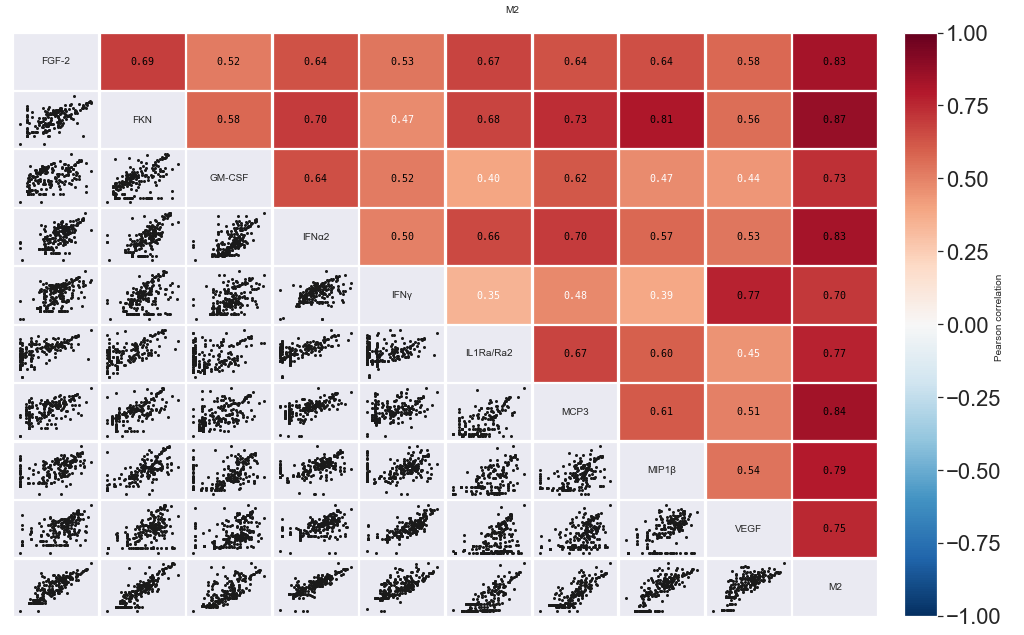

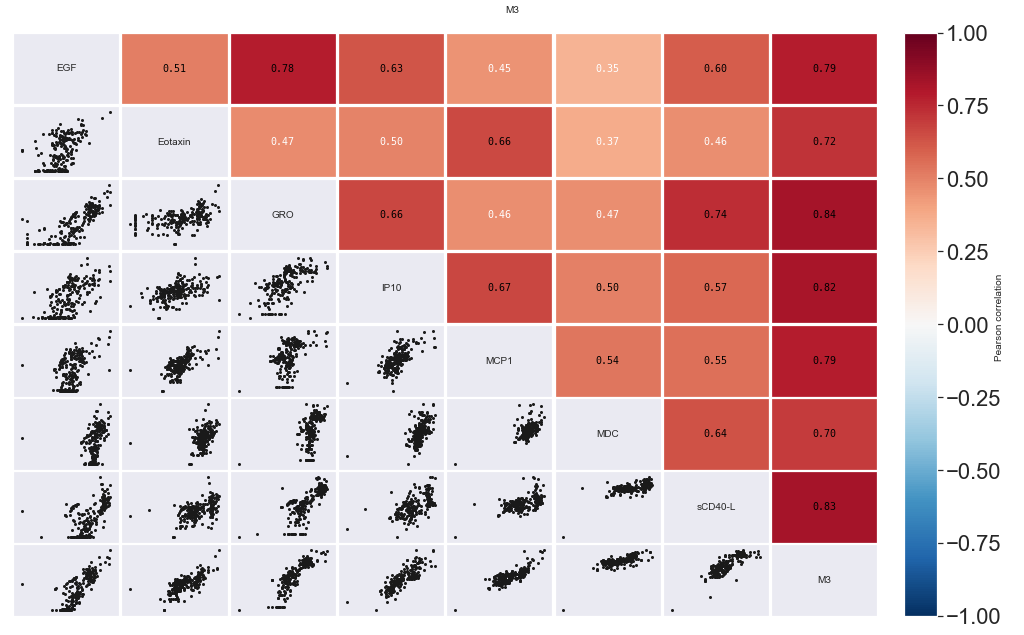

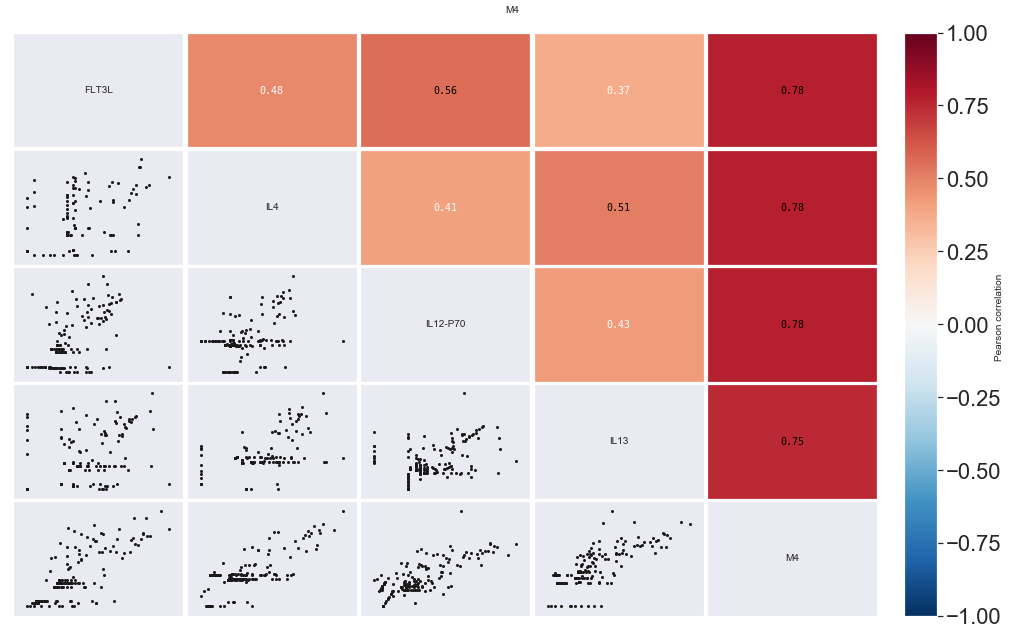

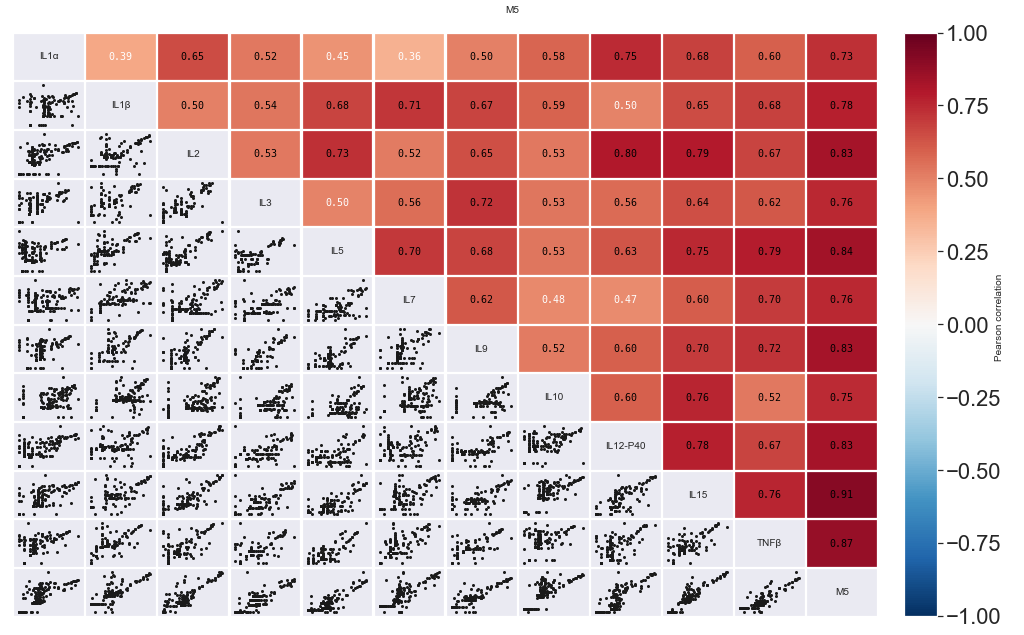

In [25]:
cytomod.io.plot_module_correl(cyto_modules['abs'], args.paths['clustering_figures'])

### <span style="color:#5757db">5.4 Adjusted cytokines clustering results visualization</span>

#### <span style="color:#8080b3">5.4.1 Pearson pairwise correlations (with module colors)</span>

<Figure size 1116x684 with 0 Axes>

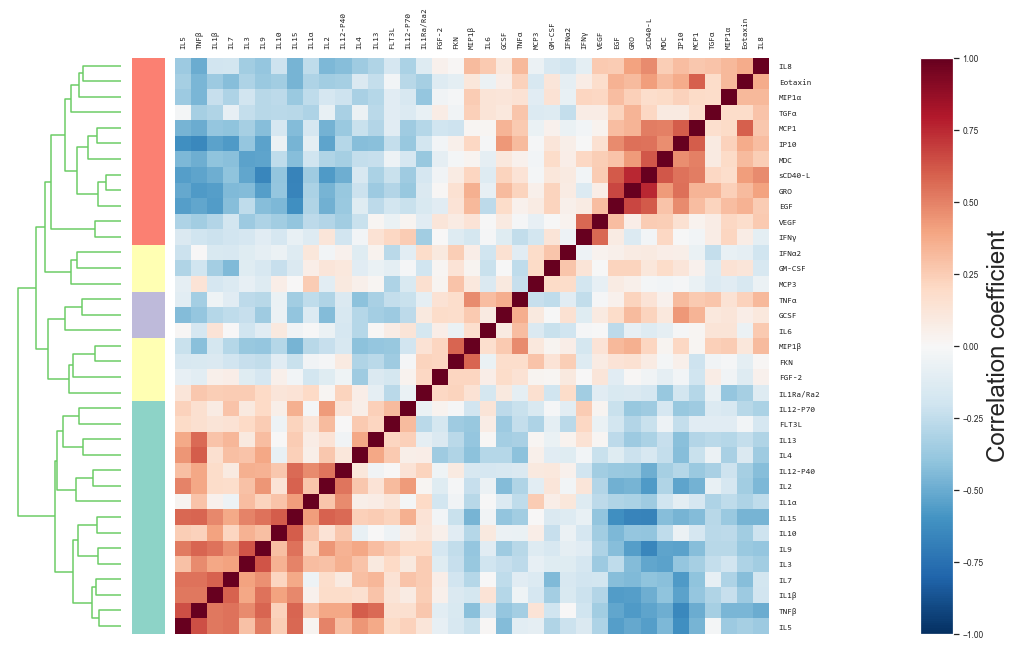

In [26]:
cytomod.io.plot_clustering_heatmap(cyto_modules['adj'], args.paths['clustering_figures'])

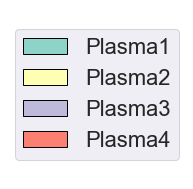

In [27]:
cytomod.io.plot_color_legend(cyto_modules['adj'], args.paths['clustering_figures'])

#### <span style="color:#8080b3">5.4.2 Pairwise same-cluster reliability (with module colors)</span>

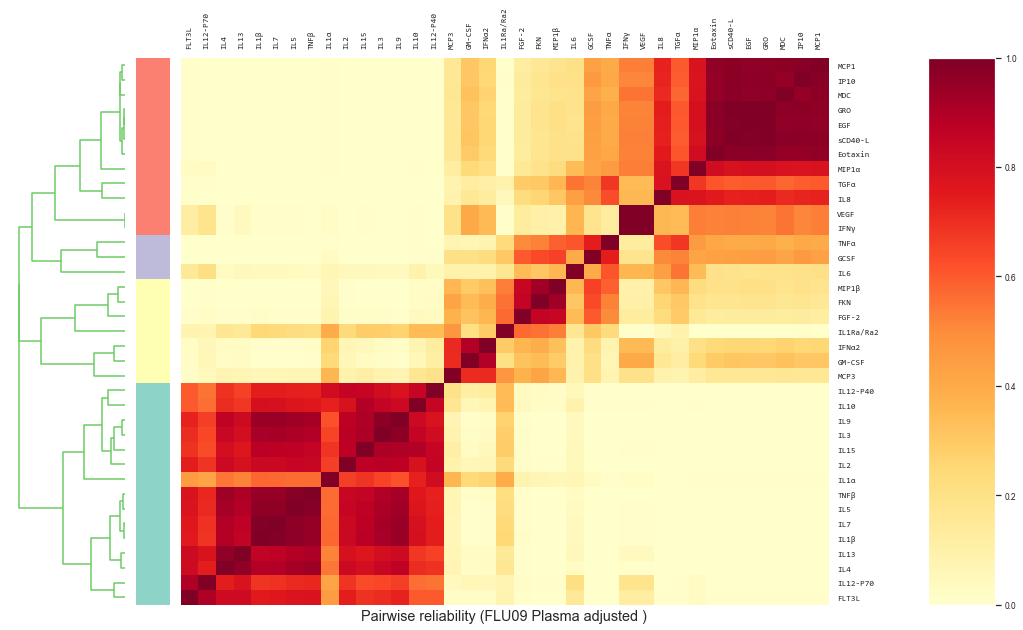

In [28]:
cytomod.io.plot_reliability(cyto_modules['adj'], args.paths['clustering_figures'])

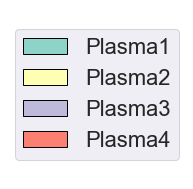

In [29]:
cytomod.io.plot_color_legend(cyto_modules['adj'], args.paths['clustering_figures'])

#### <span style="color:#8080b3">5.4.3 Modules cytokines correlations</span>

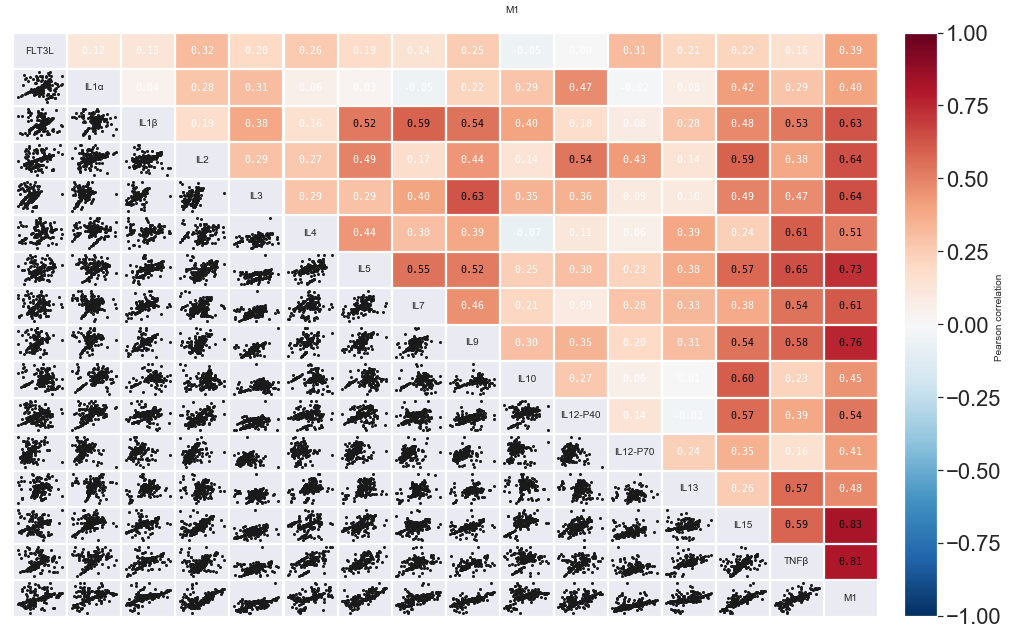

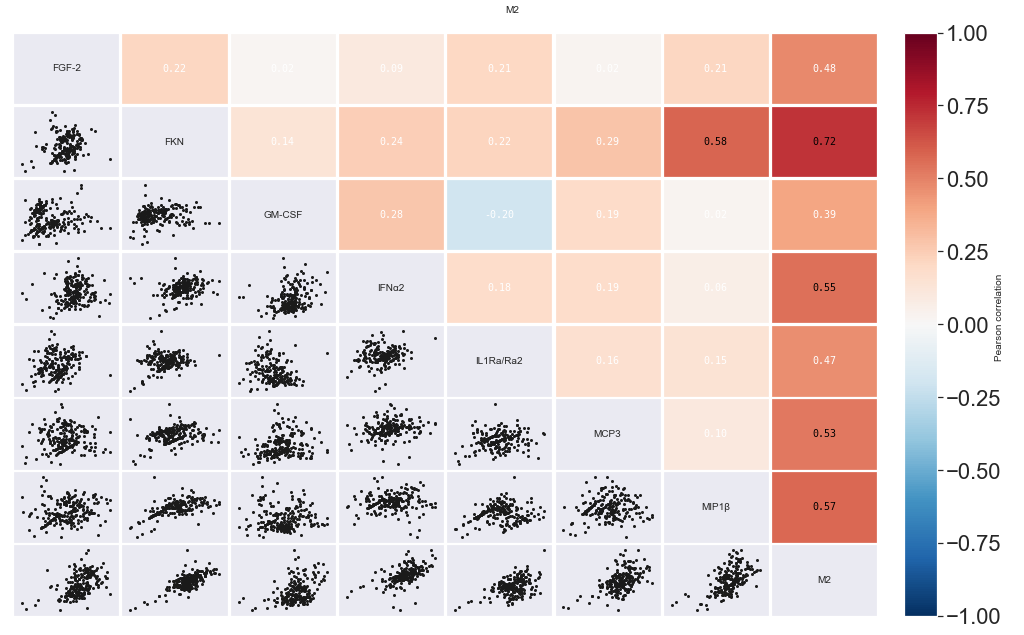

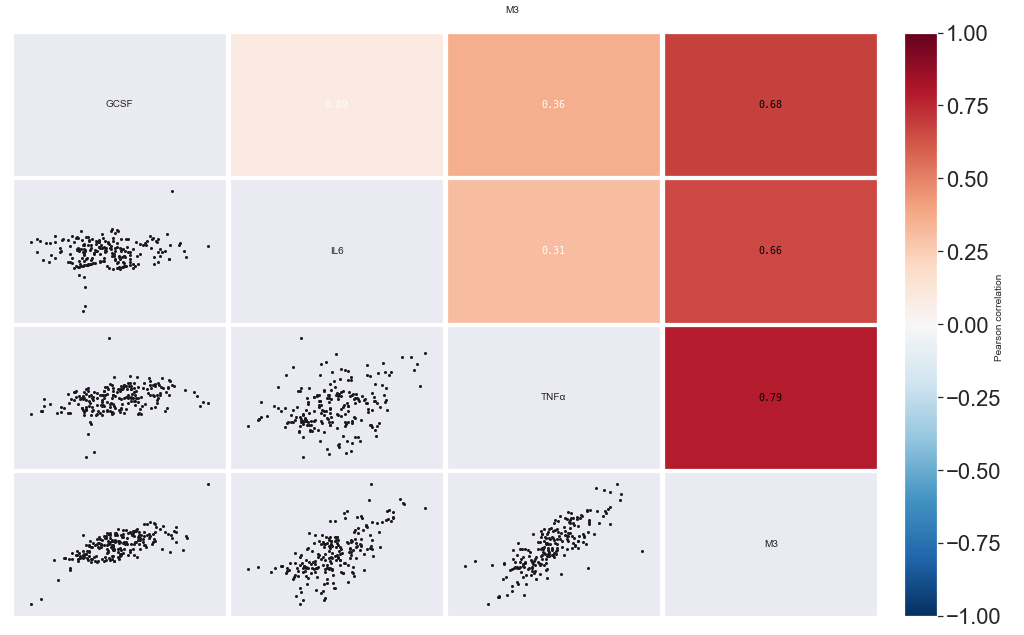

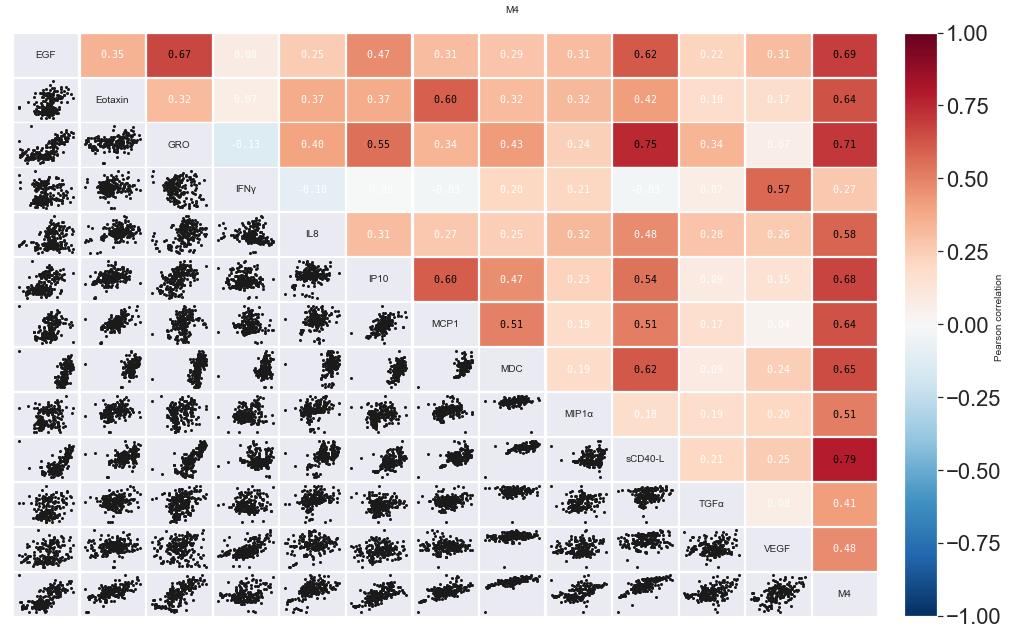

In [30]:
cytomod.io.plot_module_correl(cyto_modules['adj'], args.paths['clustering_figures'])

### <span style="color:#5757db">5.5 Write clustering results to files</span>

In [31]:
cytomod.io.write_modules(cyto_modules['abs'], args.paths['clustering_info'])
cytomod.io.write_modules(cyto_modules['adj'], args.paths['clustering_info'])

## <span style="color:purple">6. Associations to Outcomes </span>

### <span style="color:#5757db">6.1 Calculate associations</span>

#### <span style="color:#8080b3">6.1.1 Absolute </span>

In [32]:
if args.outcomes != []:
    mod_outcome_abs_df = outcome.outcomeAnalysis(cyto_modules['abs'], patient_data,
                    analyzeModules=True,
                    outcomeVars=args.outcomes,
                    adjustmentVars=args.covariates,
                    standardize=True)
    cy_outcome_abs_df = outcome.outcomeAnalysis(cyto_modules['abs'], patient_data,
                    analyzeModules=False,
                    outcomeVars=args.outcomes,
                    adjustmentVars=args.covariates,
                    standardize=True)

#### <span style="color:#8080b3">6.1.2 Adjusted </span>

In [33]:
if args.outcomes != []:
    mod_outcome_adj_df = outcome.outcomeAnalysis(cyto_modules['adj'], patient_data,
                        analyzeModules=True,
                        outcomeVars=args.outcomes,
                        adjustmentVars=args.covariates,
                        standardize=True)
    cy_outcome_adj_df = outcome.outcomeAnalysis(cyto_modules['adj'], patient_data,
                        analyzeModules=False,
                        outcomeVars=args.outcomes,
                        adjustmentVars=args.covariates,
                        standardize=True)

### <span style="color:#5757db">6.2 Figures</span>

#### <span style="color:#8080b3">6.2.1 Absolute </span>

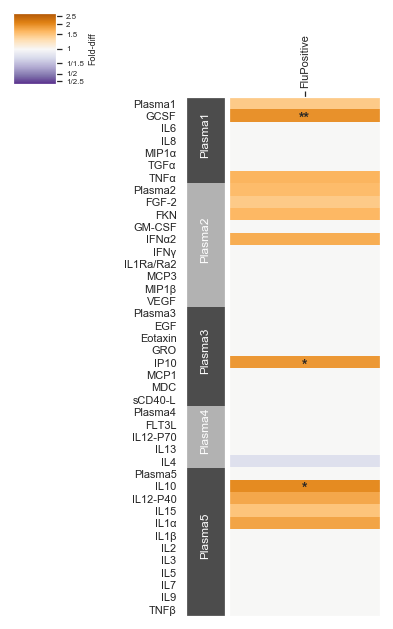

In [34]:
if args.outcomes != []:
    outcome.plotResultSummary(cyto_modules['abs'],
                              mod_outcome_abs_df,
                              cy_outcome_abs_df,
                              args.outcomes,
                              fdr_thresh_plot=0.2,
                              compartmentName=args.name_compartment,
                              figsize=(6,9),
                              save_fig_path=os.path.join(args.paths['association_figures'], 'associations_abs.png'))

#### <span style="color:#8080b3">6.2.2 Adjusted </span>

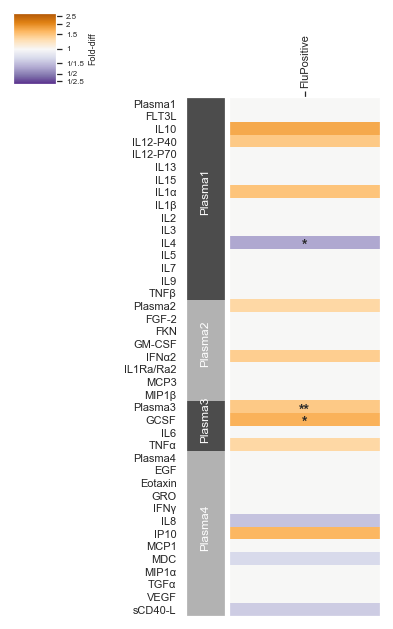

In [35]:
if args.outcomes != []:
    outcome.plotResultSummary(cyto_modules['adj'],
                              mod_outcome_adj_df,
                              cy_outcome_adj_df,
                              args.outcomes,
                              fdr_thresh_plot=0.2,
                              compartmentName=args.name_compartment,
                              figsize=(6,9),
                              save_fig_path=os.path.join(args.paths['association_figures'], 'associations_adj.png'))